In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('NVDA_data.csv')
df.head()

,Year,Week_Number,Open,Adj Close,mean_return,volatility,color_label
0,2018,0,48.945000,53.287727,1.98875,3.081352,red
1,2018,1,55.099998,55.162941,0.70180,1.397675,red
2,2018,2,56.012501,56.926830,0.80200,1.813348,green
3,2018,3,57.607498,60.197319,1.13480,1.691356,green
4,2018,4,60.685001,57.770416,-0.80300,2.021694,red


In [2]:
train_data = df[df['Year'] != 2022].copy()
test_data = df[df['Year'] == 2022].copy()

X_train = train_data[['Open', 'Adj Close', 'mean_return', 'volatility']]
y_train = train_data['color_label']

X_test = test_data[['Open', 'Adj Close', 'mean_return', 'volatility']]
y_test_true = test_data['color_label']


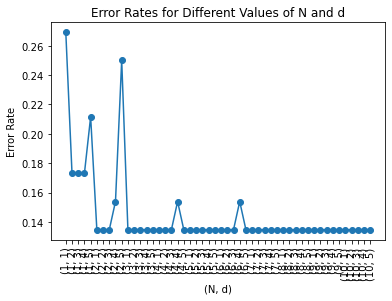

Best combination of N and d: N=2, d=1
Minimum error rate for Year 2: 0.13461538461538458


In [4]:
N_values = range(1, 11)
d_values = range(1, 6)
error_rates = {}

for N in N_values:
    for d in d_values:
        # Create random forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=N, max_depth=d, random_state=42)
        
        # Train the classifier on Year 1 data
        rf_classifier.fit(X_train, y_train)
        
        # Predict labels for Year 2 data
        y_test_pred_rf = rf_classifier.predict(X_test)
        
        # Compute error rate for Year 2
        error_rate = 1 - accuracy_score(y_test_true, y_test_pred_rf)
        
        # Store the error rate in the dictionary
        error_rates[(N, d)] = error_rate

# Find the combination of N and d with the minimum error rate
best_combination = min(error_rates, key=error_rates.get)
best_N, best_d = best_combination
min_error_rate = error_rates[best_combination]

# Plot the error rates
error_rate_values = list(error_rates.values())
plt.plot(error_rate_values, marker='o')
plt.xticks(range(len(error_rates)), list(error_rates.keys()), rotation='vertical')
plt.xlabel('(N, d)')
plt.ylabel('Error Rate')
plt.title('Error Rates for Different Values of N and d')
plt.show()

print(f'Best combination of N and d: N={best_N}, d={best_d}')
print(f'Minimum error rate for Year 2: {min_error_rate}')

In [5]:
# Using the optimal values from Year 1, confusion matrix for Year 2
optimal_rf_classifier = RandomForestClassifier(n_estimators=best_N, max_depth=best_d, random_state=42)
optimal_rf_classifier.fit(X_train, y_train)
y_test_pred_optimal_rf = optimal_rf_classifier.predict(X_test)
conf_matrix_optimal_rf = confusion_matrix(y_test_true, y_test_pred_optimal_rf)

#sensitivity (recall) and specificity for Year 2
tn_optimal_rf, fp_optimal_rf, fn_optimal_rf, tp_optimal_rf = conf_matrix_optimal_rf.ravel()
sensitivity_optimal_rf = tp_optimal_rf / (tp_optimal_rf + fn_optimal_rf)
specificity_optimal_rf = tn_optimal_rf / (tn_optimal_rf + fp_optimal_rf)

print('Confusion Matrix for Optimal Random Forest (Year 2):')
print(conf_matrix_optimal_rf)
print(f'True Positive Rate (Sensitivity) for Optimal Random Forest: {sensitivity_optimal_rf:.4f}')
print(f'True Negative Rate (Specificity) for Optimal Random Forest: {specificity_optimal_rf:.4f}')

Confusion Matrix for Optimal Random Forest (Year 2):
[[12  2]
 [ 5 33]]
True Positive Rate (Sensitivity) for Optimal Random Forest: 0.8684
True Negative Rate (Specificity) for Optimal Random Forest: 0.8571


In [6]:
accuracy_rf = accuracy_score(y_test_true, y_test_pred_optimal_rf)
print(f'Accuracy of Decision Tree for Year 2: {accuracy_rf}')

Accuracy of Decision Tree for Year 2: 0.8653846153846154


In [7]:
test_data['predicted_label'] = y_test_pred_optimal_rf
test_data.head()

,Year,Week_Number,Open,Adj Close,mean_return,volatility,color_label,predicted_label
211,2022,1,298.149994,272.118683,-1.4652,3.573360,red,red
212,2022,2,265.809998,269.072632,-0.1934,2.768013,red,red
213,2022,3,262.600006,233.438583,-3.4885,0.320452,red,red
214,2022,4,223.300003,228.105469,-0.4078,3.646720,red,red
215,2022,5,231.820007,242.876404,1.3404,4.416611,green,green


# Trading strategy for 2022 to calculate the amount at the end of the year using predicted labels

In [8]:
def trading_strategy_predicted_logistic_reg(df, initial_balance=100):
    df = df.reset_index(drop=True)  # Reset the index to numeric values
    balance = initial_balance
    position = None
    balance_history = []

    for week in range(len(df)):  # Adjust the loop condition
        open_price = df.loc[week, 'Open']
        close_price = df.loc[week, 'Adj Close']

        if df.loc[week, 'predicted_label'] == 'green':
            if position is None:
                shares_to_buy = balance / open_price
                print(f"Week {week}: Buying {shares_to_buy:.2f} shares at ${open_price:.2f}")
                position = shares_to_buy
                balance = 0
                print(f"   Shares: {position:.2f}, Portfolio Value: ${balance:.2f}")

        elif df.loc[week, 'predicted_label'] == 'red':
            if position is not None:
                balance_from_selling = position * df.loc[week - 1, 'Adj Close']
                print(f"Week {week}: Selling {position:.2f} shares at ${df.loc[week - 1, 'Adj Close']:.2f}, "
                      f"Portfolio Value: ${balance_from_selling:.2f}")
                balance += balance_from_selling
                position = None
                print(f"   Portfolio Value: ${balance:.2f}")

        if position is None:
            portfolio_value = balance
        else:
            portfolio_value = position * df.loc[week - 1, 'Adj Close']

        balance_history.append(portfolio_value)
        print(f"Week {week}: Portfolio Value: ${portfolio_value:.2f}")

    return balance_history

resulting_balance_history_lr = trading_strategy_predicted_logistic_reg(test_data)
print("Balance History based on Modified Predicted Labels for 2022:", resulting_balance_history_lr[-1])


Week 0: Portfolio Value: $100.00
Week 1: Portfolio Value: $100.00
Week 2: Portfolio Value: $100.00
Week 3: Portfolio Value: $100.00
Week 4: Buying 0.43 shares at $231.82
   Shares: 0.43, Portfolio Value: $0.00
Week 4: Portfolio Value: $98.40
Week 5: Selling 0.43 shares at $242.88, Portfolio Value: $104.77
   Portfolio Value: $104.77
Week 5: Portfolio Value: $104.77
Week 6: Portfolio Value: $104.77
Week 7: Buying 0.45 shares at $230.35
   Shares: 0.45, Portfolio Value: $0.00
Week 7: Portfolio Value: $107.39
Week 8: Selling 0.45 shares at $241.26, Portfolio Value: $109.73
   Portfolio Value: $109.73
Week 8: Portfolio Value: $109.73
Week 9: Portfolio Value: $109.73
Week 10: Buying 0.50 shares at $218.69
   Shares: 0.50, Portfolio Value: $0.00
Week 10: Portfolio Value: $110.77
Week 11: Portfolio Value: $132.58
Week 12: Selling 0.50 shares at $276.61, Portfolio Value: $138.79
   Portfolio Value: $138.79
Week 12: Portfolio Value: $138.79
Week 13: Portfolio Value: $138.79
Week 14: Portfolio V